# Questions
### 1. Distribution of the customers within each sector (Ratio & Percentage of customers per cluster divided by the total number of customers)
### 2. Statistics of each cluster (Min, Max, Median of clustering RFM attributes)
### 3. Describe the distinct features of each cluster. (Based on what is most desirable to retailers, such as most/least valuable customers, most/least loyal customers, purchase patterns)


### Authors
- Dustin Pulver
- Alex Koch
- Apollo Lin


All Libraries used in this assignment are displayed in the cell below. Running the below cell should be all the is required to properly install these libraries into this environment. The cell below it has code to install packages if for some reason it does not work in the first cell. 

You will need to have one excel file called Online Retail.xlsx. You need to modify the os.chdir to match your local directory containing unzipped folder with the notebook and the excel file before running the following code.

In [51]:
import os

os.chdir(".\\Customer-Segmentation")

#library used to read excel files
import openpyxl 
#library used to manipulate and create dataframe
import pandas as pd
import numpy as np
import math
#library used to create a date
import datetime as dt
#library used to iterate through data structures
from itertools import chain
#library used to plot and visualize the data
import matplotlib.pyplot as plt
#importing tools to use for 3D plotting
import re, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
#clustering library
from sklearn import *
from sklearn.cluster import KMeans
#module used to perform internal validation for clusters
from sklearn.metrics import silhouette_score

Before proceeding to clustering, we will begin by examining the data through data exploration to identify some trends and anomolies.

In [52]:
# Because the file is in excel format, reading file with pd.read_excel
filePath = "Online Retail.xlsx"
retail_raw = pd.read_excel(filePath)

In [53]:
#The dataset has 541909 rows and 8 features
retail_raw.shape
retail_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [54]:
# Previewing the dataset shows that we have a combinatino of both numerical and categorical data
# It also shows that one custoemer can buy many items in the same purchase, the first 9 rows were all items
# purchases by the same customer 
retail_raw.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,10002,INFLATABLE POLITICAL GLOBE,48,2010-12-01 08:45:00,0.85,12583.0,France
1,536382,10002,INFLATABLE POLITICAL GLOBE,12,2010-12-01 09:45:00,0.85,16098.0,United Kingdom
2,536756,10002,INFLATABLE POLITICAL GLOBE,1,2010-12-02 14:23:00,0.85,NaN,United Kingdom
3,536863,10002,INFLATABLE POLITICAL GLOBE,1,2010-12-03 11:19:00,0.85,17967.0,United Kingdom
4,536865,10002,INFLATABLE POLITICAL GLOBE,5,2010-12-03 11:28:00,1.66,NaN,United Kingdom
5,536876,10002,INFLATABLE POLITICAL GLOBE,2,2010-12-03 11:36:00,1.66,NaN,United Kingdom
6,537047,10002,INFLATABLE POLITICAL GLOBE,1,2010-12-05 11:02:00,0.85,13069.0,United Kingdom
7,537227,10002,INFLATABLE POLITICAL GLOBE,24,2010-12-06 08:42:00,0.85,17677.0,United Kingdom
8,537240,10002,INFLATABLE POLITICAL GLOBE,1,2010-12-06 10:08:00,1.66,NaN,United Kingdom
9,537638,10002,INFLATABLE POLITICAL GLOBE,5,2010-12-07 15:28:00,1.66,NaN,United Kingdom


In [55]:
# Upon exploring null values, we found a large amount (135080) of nulls in the customer ID fields
retail_raw.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [56]:
# Upon inspecting more closely, we realized that out of the numerical values, there are some anomalies
# For example, UnitPrice and Quantity should not be possibly below zero 
# By looking at the Description attribute for these negative values, we also realized they are mostly damages/other miscellaneous circumstances
# All of the none refund type negative value also corresponds to a CustomerID of zero (null); therefore we can conclude that these rows will not help with clustering 
# because they fail to associate with any customer
retail_raw.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


At this point, we are taking the approach of not generating artificial customer IDs to fill the null values. The reason being:  
1. There are no reasonable criteria to apply grouped statistic replacement. Customers in the same geography & purchase time do not necessarily mean it is the same customer as supported by real customer records.  
2. Imputation is the only viable method BUT would alter the clustering result. Even if we can generate artificial customers, these hypothetical customers are NOT present in the real world. 

Because the nature of this problem is clustering and not supervised learning, it would be more harmful to generate artificial records than to delete them. Given that we still have plenty of records to work with the following deletion, we believe it is best to create Real, Meaningful clusters of real customers rather than having artificial customers that might confuse the algorithm, leading to inaccurate representation of real-world customers. 

From here, because negative UnitPrice does not make sense in our clustering, we should examine it further.  

In [57]:
# Upon closer examination, we discovered there are only two UnitPrices below zero
helper = retail_raw[retail_raw.UnitPrice < 0]
helper.UnitPrice.value_counts()
# Displaying the rows where UnitPrice is below 0
# As we can tell, these seems to be irrelevant information and an error in the system, therefore we can simply drop moving forward
helper.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
538949,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
538950,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [58]:
# Because there are dates outside the specified study period, we need to remove them first

val_period = retail_raw.loc[retail_raw["InvoiceDate"].between("2010-12-01","2011-12-09")]

In [59]:
# Double checkign to see how many transactions are withi the valid transaction period
print(val_period.shape, retail_raw.shape)

(540277, 8) (541909, 8)


In [60]:
# We need to filter our invalid transactions such as discounts, shipping, etc.
valid_stock = val_period.dropna(subset=["CustomerID","StockCode"])
# Changing column type to str to avoid NaN error
valid_stock["StockCode"] = valid_stock["StockCode"].astype(str)
# Getting rid of StockCode that does not contain number, they are stock codes for discounts, postage, and other NONE PURCHASE type transactions
valid_stock = valid_stock[valid_stock["StockCode"].str.contains("\d")]


C:\Users\apoll\AppData\Local\Temp/ipykernel_10076/1507028322.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_stock["StockCode"] = valid_stock["StockCode"].astype(str)


In [61]:
# After dropping the invalid StockCodes, we have 404425 valid transactions left
valid_stock.shape

(404425, 8)

In [62]:
# After dealing with the UnitPrice, we can examine the negative Quantity information.
# As outlined in the documentation, negative Quantity is associated with returns, which are relevant to our analysis. Because returns void
# the purchase amount of a previous item, and would therefore affect the RFM values generated

# Creating a df containing only returns and valid customer IDs 
retail_return = valid_stock[(valid_stock.Quantity < 0) & valid_stock.UnitPrice > 0 & (valid_stock['InvoiceNo'].str.contains("C"))]

In [63]:
# Double checking to make sure the extracted data is correct
# There are 8534 records of returned merchandise by customers
retail_return.head(10)
retail_return.shape

(8534, 8)

In [64]:
# dropping all the null customerIDs, leaving behind viable information used to generate RFM
retail_non_return = valid_stock[~valid_stock["InvoiceNo"].str.contains("C", na=False)]

In [65]:
# Non-return dataframe has 395891 rows with no null values
retail_non_return.isnull().sum()
retail_non_return.shape


(395891, 8)

Due to the nature of returns, we decided not to include returns as part of recency or frequency calculations because they are **NOT a PURCHASE** transaction.

"RFM (Recency, Frequency, Monetary) analysis2 is a marketing technique used to determine quantitatively which
customers are the best ones by examining how recently a customer has purchased (recency), how often they purchase
(frequency), and how much the customer spends (monetary)."  

As a result, we will only use refunds for monetary calculations.

In [66]:
retail_non_return.head(10)
    

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,10002,INFLATABLE POLITICAL GLOBE,48,2010-12-01 08:45:00,0.85,12583.0,France
1,536382,10002,INFLATABLE POLITICAL GLOBE,12,2010-12-01 09:45:00,0.85,16098.0,United Kingdom
3,536863,10002,INFLATABLE POLITICAL GLOBE,1,2010-12-03 11:19:00,0.85,17967.0,United Kingdom
6,537047,10002,INFLATABLE POLITICAL GLOBE,1,2010-12-05 11:02:00,0.85,13069.0,United Kingdom
7,537227,10002,INFLATABLE POLITICAL GLOBE,24,2010-12-06 08:42:00,0.85,17677.0,United Kingdom
12,537770,10002,INFLATABLE POLITICAL GLOBE,12,2010-12-08 12:24:00,0.85,15529.0,United Kingdom
14,538069,10002,INFLATABLE POLITICAL GLOBE,8,2010-12-09 14:08:00,0.85,16795.0,United Kingdom
16,538086,10002,INFLATABLE POLITICAL GLOBE,10,2010-12-09 14:44:00,0.85,12872.0,United Kingdom
17,538093,10002,INFLATABLE POLITICAL GLOBE,12,2010-12-09 14:49:00,0.85,12682.0,France
18,538167,10002,INFLATABLE POLITICAL GLOBE,12,2010-12-09 18:58:00,0.85,14713.0,United Kingdom


retail_poz.

In [67]:
# Setting end date to compute recency
end_date = dt.datetime(2011, 12, 9)
end_date.year

2011

In [68]:
# calculating recency and frequency using data without returns
rf = retail_non_return.groupby("CustomerID").agg({"InvoiceDate": lambda date: ((end_date.year - date.max().year)*12 + end_date.month - date.max().month),
                                                'InvoiceNo': lambda num: num.nunique()})

In [69]:
# rf identified 4334 unique customers with aggregated recency and frequency data
rf.shape
# checking if there are dates outside the range, returns 0
rf["InvoiceDate"].lt(0).sum().sum() 

0

In [70]:
# calculating monetary value by aggregating return with non-returns, the returns are added back here because they DO impact the total amount a customre has spent
# people who return merchandise frequently or in high amounts means they are not a good customer since there is low completed transactiosn (actually purhcased)
monetary = [retail_non_return,retail_return]
monetary = pd.concat(monetary)


In [71]:
# Generating total monetary value per customer
monetary["TotalPrice"] = monetary["UnitPrice"] * monetary["Quantity"]

In [72]:
# Generating the aggregated sum of total price of all the purchases per customer
monetary = monetary.groupby("CustomerID").agg({"TotalPrice": lambda TotalPrice: TotalPrice.sum()})

In [73]:
# double checking the shape of the dataframe, there are 4362 customers with purchase values
monetary.shape

(4362, 1)

In [74]:
# Joining dataframe on CustomerID to obtain final rfm dataframe
rfm = rf.join(monetary, on="CustomerID")


In [75]:
# Renaming the columns
rfm = rfm.set_axis(["Recency", "Frequency", "Monetary"],axis="columns", inplace=False)
# Checking for missing values, no missing values
rfm.isnull().sum()

Recency      0
Frequency    0
Monetary     0
dtype: int64

Now that we have the rfm dataframe, we can:
1. Return the Sum, Min, Median, Max for each customer
2. From the statistics look for outliers and isolate them
3. Normalize attributes before feeding them through the algorithm

In [76]:
# Describing the rim statistics for the aggregated customer base as per the hint section
# The average month of all customers' last purchases is 3.2 months, and the max is one year(as per the study period is around 12 months)
# The average number of transactions is 4.23, and the max is 205, which is very high
# The average dollar amount per purchase is 1910, and the min is -141.48, which means the customer returned more than they purchased (potentially from purchases outside of the study period)
# The max dollar amount is 278778.02, again an abnormally high numbers 

rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4334.0,3.236733,3.285728,0.00,1.0,2.00,5.0000,12.00
Frequency,4334.0,4.237886,7.624582,1.00,1.0,2.00,5.0000,205.00
Monetary,4334.0,1910.843655,8301.227636,-141.48,298.9,652.07,1601.6275,278778.02


In [77]:
# Showing the most frequent value from the rfm dataset
rfm.median()


Recency        2.00
Frequency      2.00
Monetary     652.07
dtype: float64

In [78]:
# Showing the sum of the values, this is less applicable to recency, mostly pertaining to frequency and monetary
rfm.sum()

Recency        14028.0
Frequency      18367.0
Monetary     8281596.4
dtype: float64

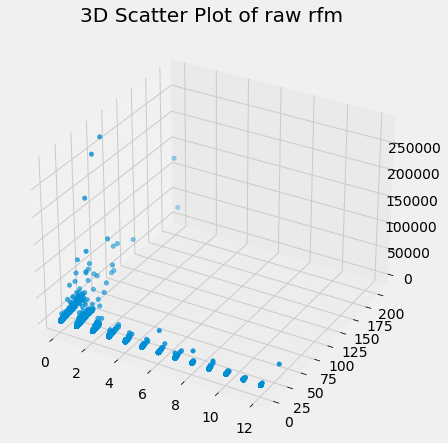

In [79]:
# Scatter Plot of raw rfm data, as we can see there are many outliers, some of them are anomolies that should be removed
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(rfm["Recency"], rfm["Frequency"], rfm["Monetary"])
plt.title("3D Scatter Plot of raw rfm")
plt.show()

Because there are many outliers, as shown in the plot above, we will be isolating the outliers before proceeding.  

Due to the nature of this being in an unsupervised environment, it is difficult to determine outliers with dbscan/svm since there is no target. As a result, we will be using the 1.5*IQR standard when assessing which values are outliers.

In [80]:
# Isolating outliers before normalizatino and clustering to avoid wrong clusters
def IQR_separate(df):
    no_outliers = pd.DataFrame()
    for column in df:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        no_outliers = df[df[column] > (Q1 - 1.5*IQR )]
        no_outliers = no_outliers[no_outliers[column]< (Q3 + 1.5*IQR)]

    return no_outliers

In [81]:
# assigning outliers and non outliers to corresponding dfs
rfm_n = IQR_separate(rfm)
rfm_o = pd.concat([rfm,rfm_n]).drop_duplicates(keep=False)

In [82]:
# describing outliers, evidently, they captuer some of the extreme values shown before
rfm_o.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,411.0,0.936740,1.440152,0.00,0.00,1.00,1.00,12.00
Frequency,411.0,16.851582,19.296654,1.00,8.00,12.00,19.00,205.00
Monetary,411.0,11915.572701,24721.139261,3563.11,4363.05,5811.56,9394.96,278778.02


We will normalize the cleaned data in order to achieve better results with clustering later.

In [83]:
# making a copy of the cleaned dataframe
df_min_max_scaled = rfm_n.copy()
  
# apply min-max normalization technique
for column in df_min_max_scaled.columns:
    df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
  
# making sure the data is correctly normalized
df_min_max_scaled.head(10)

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,0.916667,0.000000,0.038319
12348.0,0.250000,0.078947,0.427582
12349.0,0.083333,0.000000,0.433083
12350.0,0.833333,0.000000,0.118054
12352.0,0.083333,0.157895,0.381044
12353.0,0.583333,0.000000,0.062423
12354.0,0.666667,0.000000,0.330665
12355.0,0.583333,0.000000,0.162743
12356.0,0.083333,0.052632,0.712017


In order to find the optimal number of meaningful clusters, we will enlist the help of statistics in combination with industry information.

The first method we are using is the Sum of Squares Error; by finding the elbow of the sse score, we can determine a statistically good amount of clusters.

The second method we are using is a built-in form of internal validation called silhouette score. The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. As a result, it accounts for both compactness and separation. We are looking for the highest silhouette score possible out of the number of clusters. 

In [84]:
# Confiuring k-means used for the experiment
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k (number of clusters)
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_min_max_scaled)
    sse.append(kmeans.inertia_)
 


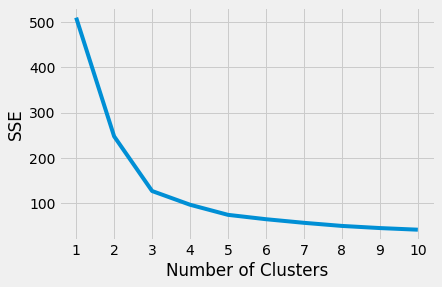

In [85]:
 # Plotting the sse against number of clusters, as we can see k = 3 marks the elbow point
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [86]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_min_max_scaled)
    score = silhouette_score(df_min_max_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

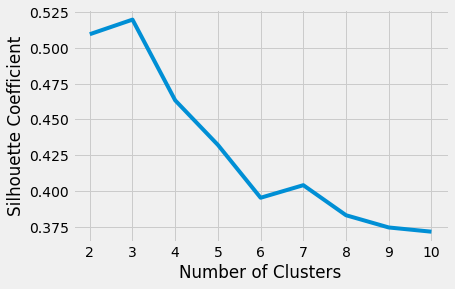

In [87]:
# Plotting the silhoutte coefficients against number of clusters, as captured, 3 clusters denote the highest score 
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [88]:
# From the result earlier, choosing to perform k-means clustering with 3 clusters 
kmeans = KMeans(n_clusters=3, random_state = 42)
kmeans.fit(df_min_max_scaled)


KMeans(n_clusters=3, random_state=42)

In [89]:
# Center points of each cluster
kmeans.cluster_centers_

array([[0.16386716, 0.03476881, 0.19289889],
       [0.72236796, 0.01165295, 0.1440533 ],
       [0.11595567, 0.1395034 , 0.64050032]])

In [90]:
# Defining function to plot 3D scatterplots with colour coded points
def threeDplot(df, colour):
    fig = plt.figure(figsize=(5.5,5.5))
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)


    sc = ax.scatter(df["Recency"], df["Frequency"], df["Monetary"], s=40, c=df["cluster"], marker='o', alpha=1)

    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')

    plt.set_cmap(colour) 

    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

    plt.show()

In [91]:
# making a copy and merging clustering results 
norm_labels = df_min_max_scaled.copy()
norm_labels.loc[:,"cluster"] = kmeans.labels_

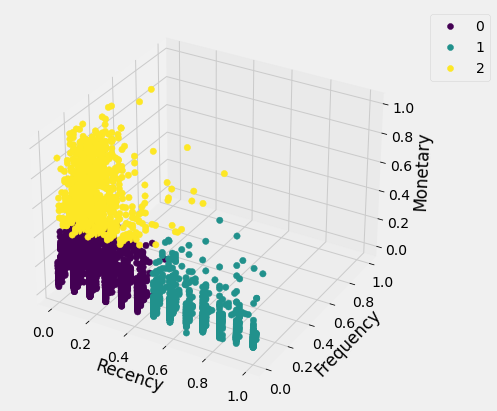

In [92]:
# plotting the clustering results of 3 cluters in a 3D space
threeDplot(norm_labels, "brg")

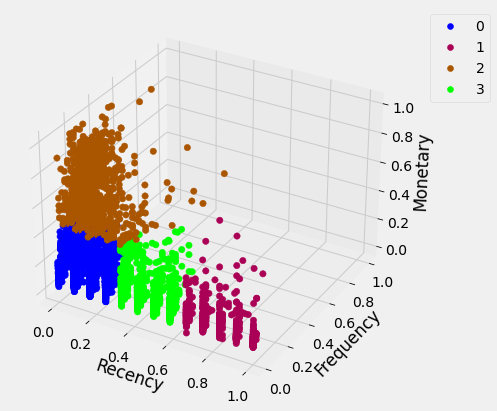

In [93]:
#Repeating process with 4 clusters
kmeans = KMeans(n_clusters=4, random_state = 0)
kmeans.fit(df_min_max_scaled)

four_labels = df_min_max_scaled.copy()
four_labels.loc[:,"cluster"] = kmeans.labels_

# plotting the clustering results of 4 cluters in a 3D space
threeDplot(four_labels, "brg")


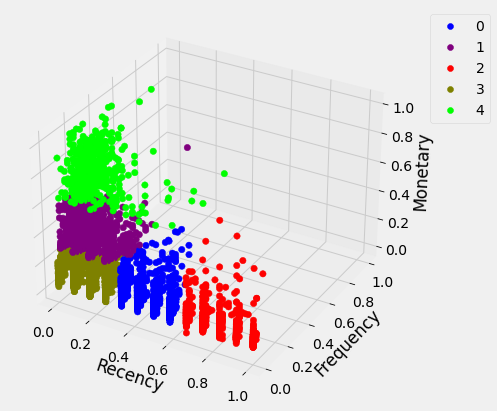

In [94]:
# Repeating process with 5 clusters
kmeans = KMeans(n_clusters=5, random_state = 0)
kmeans.fit(df_min_max_scaled)

five_labels = df_min_max_scaled.copy()
five_labels.loc[:,"cluster"] = kmeans.labels_

# plotting the clustering results of 5 cluters in a 3D space
threeDplot(five_labels, "brg")

As visible per the three plots above, it is possible to make 3-5 clusters; as 5 and beyond, the scores begin to decrease sharply. Thus we are not considering the possibility of 5+ clusters since there are more and more potentially "misclassified" clusters. 

However, given the statistical evidence from earlier, we ultimately believe that three customer clusters are the optimal way of dividing up the customer base. We will go ahead and answer the questions based on the 3 cluster conclusion.

### Question 1: Distribution of the customers within each sector (Ratio & Percentage of customers per cluster divided by the total number of customers)

In [95]:
# Making a final copy to use for questions related data manipulation
final_cluster = norm_labels.copy()
final_cluster["CustomerID"] = final_cluster.index
final_cluster.index.name = None

In [96]:
# Calculating ratio and percentages of customers in each respective cluster
ratio = final_cluster.groupby(by=["cluster"])["CustomerID"].count()

In [97]:
# There are 2172 customers in cluster 0, 953 in cluster 1 and 798 in cluster 2
ratio

cluster
0.0    2172
1.0     953
2.0     798
Name: CustomerID, dtype: int64

As a result, the percentage of the respective clusters are: 
1. Cluster 0: 55.36579148610757%
2. Cluster 1: 24.292633188886056%
3. Cluster 2: 20.341575325006372%

The ratio between the clusters is:  
Cluster 0 : Cluster 1 : Cluster 2  
5.6 : 2.4 : 2.0

We are aware there are outlier customers, but because they were not part of the cluster, we are not taken them into account here.

### Question 2: Statistics of each cluster (Min, Max, Median of clustering RFM attributes)

In [98]:
# Assigning clusering results to original rfm attributes
rfm_n["CustomerID"] = rfm_n.index
rfm_n.index.name = None
dropped = final_cluster.drop(columns=["Recency","Frequency","Monetary"])
rfm_w_cluster = dropped.merge(rfm_n, how="inner")

In [99]:
# Obtaining statistics from customers in each cluster
rfm_w_cluster.groupby("cluster")["Recency","Frequency","Monetary"].describe().T

C:\Users\apoll\AppData\Local\Temp/ipykernel_10076/2200737451.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rfm_w_cluster.groupby("cluster")["Recency","Frequency","Monetary"].describe().T


cluster                   0.0          1.0          2.0
Recency   count  2.172000e+03   953.000000   798.000000
          mean   1.966851e+00     8.668416     1.390977
          std    1.384858e+00     1.995588     1.354399
          min    0.000000e+00     6.000000     0.000000
          25%    1.000000e+00     7.000000     1.000000
          50%    2.000000e+00     9.000000     1.000000
          75%    3.000000e+00    10.000000     2.000000
          max    5.000000e+00    12.000000     9.000000
Frequency count  2.172000e+03   953.000000   798.000000
          mean   2.320442e+00     1.442812     6.298246
          std    1.478071e+00     0.856962     3.466096
          min    1.000000e+00     1.000000     1.000000
          25%    1.000000e+00     1.000000     4.000000
          50%    2.000000e+00     1.000000     6.000000
          75%    3.000000e+00     2.000000     8.000000
          max    1.000000e+01     6.000000    39.000000
Monetary  count  2.172000e+03   953.000000   798.000000
          mean   5.703670e+02   390.393610  2222.323070
          std    3.573806e+02   362.464758   612.343156
          min   -1.065814e-14  -141.480000  1292.590000
          25%    2.776125e+02   157.200000  1698.497500
          50%    5.067950e+02   294.120000  2111.700000
          75%    8.162025e+02   468.770000  2680.820000
          max    1.506120e+03  2917.320000  3550.720000

In [100]:
# Obtaining median of customers in each cluster
rfm_w_cluster.groupby("cluster")["Recency","Frequency","Monetary"].median()

C:\Users\apoll\AppData\Local\Temp/ipykernel_10076/4107630189.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rfm_w_cluster.groupby("cluster")["Recency","Frequency","Monetary"].median()


,Recency,Frequency,Monetary
cluster,,,
0.0,2.0,2.0,506.795
1.0,9.0,1.0,294.120
2.0,1.0,6.0,2111.700


Given the information provided above, we can answe Q2. We can also notice that there is distinction between the statistical values across the clusters. This once again proces that the clustering was successful as these are different types of customers.

### Question 3: Describe the distinct features of each cluster. (Based on what is most desirable to retailers, such as most/least valuable customers, most/least loyal customers, purchase patterns)

To answer this question, we created a series of boxplots that compared each of the rfm attributes across the 3 clusters.

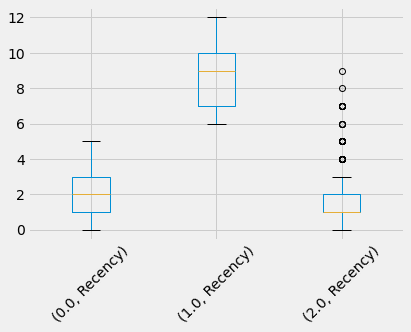

In [101]:
# Recency attribute across 3 clusters
ox_p = rfm_w_cluster.groupby("cluster").boxplot(subplots =False, rot = 45, column=["Recency"])

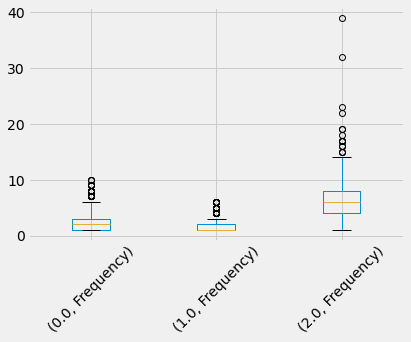

In [102]:
# Frequency attribute across 3 clusters
box_p = rfm_w_cluster.groupby("cluster").boxplot(subplots =False, rot = 45, column=["Frequency"])

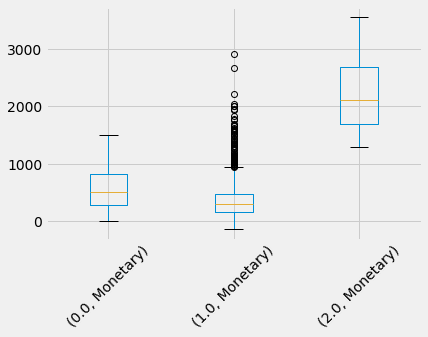

In [103]:
# Monetary attribute across 3 clusters
box_p = rfm_w_cluster.groupby("cluster").boxplot(subplots =False, rot = 45, column=["Monetary"])

In combination with the stasitics from Q2, we can derive the following distinct features for the customers from each of the clusters, we will be denoting the score in the following format: **(Recency, Frequency, Monetary) using H for High, M for Moderate, L for Low.** For example HHL means high recency, high frequency, and low monetary value.  

High recency means **low recency value** (closer to the end date), high frequency means high frequency value (more purchases made during the period), high monetary value means high monetary value (more money spent combined during the period).

1. Cluster 0: MMM  
    MMM means moderate across three attributes. These types of customers are essentially the average consumer of the company. Evidently, they also make up the largest cluster compared to the other two. This means they are customers that shop throughout the year but don't end up spending a lot of money. However, given the large base of this cluster, there can be general marketing tactics for the group. For example, discounts and sales, new catalogue reminders, etc. The goal is to keep them at this rate of spending and potentially make them into more loyal customers.

2. Cluster 1: LL L(with outliers)  
    LLL is not a good sign for this cluster. It means this type of customer is either not valuable or waiting to be discovered. This type of customer makes few purchases and visits the merchant infrequently, meaning they are likely shopping somewhere else(or they shop around for more competitive prices); they also mostly have lower spending though with exceptions. This again indicates they might be shopping around for deals(for example, if the merchant had a sale in a particular month, they would make a more significant purchase but then not return until the next sale). A potential marketing strategy for this type of customer would be to invite them to join a loyalty program with rewards. Having sales might attract and grow them to become more stable customers as well.


3. Cluster 2: H(with outliers) HH  
    Finally, we have the loyal and big spenders scoring HHH across three attributes. This means that the type of customers visits frequently and have visited recently. They also have big combined spending throughout the period, significantly higher than the other two clusters. As indicated in the instructions, these customers might be wholesalers, given their high monetary value in comparison to the other two clusters. Potential marketing strategies for this type of customer would be new/unique pricing strategies, cross-sell, and upselling. Since they are making big purchases in quantity and monetary value, the merchant can offer bundled discounts. The merchant can also consider wholesaler programs such as a credit card/line-of-credits that give low/interest-free borrowing up to their account limit. This way, the merchant can maximize their spending at their store and also potentially generate interest income from the financing income. This would incentivize the wholesalers to purchase more products even with a limited cash flow.